In [57]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import torch.nn.functional as F
from ucimlrepo import fetch_ucirepo 
import pandas as pd


In [2]:
# run this to download the dataset
!pip install ucimlrepo


In [ ]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
data = heart_disease.data.features # data 
labels = heart_disease.data.targets # labels


data['ca'].fillna(data['ca'].median(), inplace=True)
data['thal'].fillna(data['thal'].mode()[0], inplace=True)

categorical_cols = ['cp', 'restecg', 'slope', 'thal']
dataEncoded = pd.get_dummies(data, columns=categorical_cols)

scaler = StandardScaler()
dataScaledNp = scaler.fit_transform(dataEncoded)
dataScaled = pd.DataFrame(dataScaledNp, columns=dataEncoded.columns)
labels = (labels > 0).astype(int)
#convert to pytorch tensors
data = torch.tensor(dataScaled.values, dtype=torch.float32)
labels = torch.tensor(labels.values, dtype=torch.float32).reshape(-1, 1)


# Check shape of features and labels
print(data.shape)
print(labels.shape)



torch.Size([303, 22])
torch.Size([303, 1])


/var/folders/0q/p8n5d56n6vv8chg1kdq_4cwc0000gn/T/ipykernel_31018/3537326030.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ca'].fillna(data['ca'].median(), inplace=True)
/var/folders/0q/p8n5d56n6vv8chg1kdq_4cwc0000gn/T/ipykernel_31018/3537326030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ca'].fillna(data['ca'].median(

164

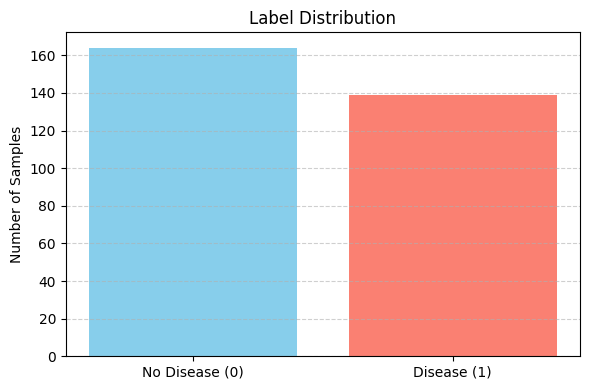

In [345]:

# Convert to numpy for plotting
labels_np = labels.numpy().flatten()

# Count class occurrences
class_counts = [sum(labels_np == 0), sum(labels_np == 1)]

# Bar plot
plt.figure(figsize=(6,4))
plt.bar(["No Disease (0)", "Disease (1)"], class_counts, color=["skyblue", "salmon"])
plt.title("Label Distribution")
plt.ylabel("Number of Samples")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [357]:
# spliting the data 
xTrain, xTest, yTrain, yTest = train_test_split(data, labels, test_size=0.2)

# create dataset
xTrainDataset = torch.utils.data.TensorDataset(xTrain, yTrain)
xTestDataset = torch.utils.data.TensorDataset(xTest, yTest)
# create dataloaders
batchSize = 16
trainLoader = DataLoader(xTrainDataset, batch_size = batchSize, shuffle=True, drop_last=True)
testLoader = DataLoader(xTestDataset, batch_size=xTestDataset.tensors[0].shape[0])


In [358]:
# create the model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(22,32)
        self.hidden = nn.Linear(32, 16)
        self.output = nn.Linear(16,1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x,p=0.2,training=self.training) # switch dropout off during .eval()
        x = F.relu(self.hidden(x))
        return self.output(x)
    

In [ ]:
numEpochs = 100

def trainTheModel(model):
    trainAcc = []
    testAcc = []
    losses = np.zeros(numEpochs)

    lossFun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(heartDisease.parameters(), lr=0.001, weight_decay=1e-5)  # L2 reg

    for epochi in range(numEpochs):
        heartDisease.train()
        batchAcc = []
        batchLoss = []
        for x, Y in trainLoader:
            yHat = heartDisease(x)
            loss = lossFun(yHat, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = (torch.sigmoid(yHat) > 0.5).float()
            acc = (preds == Y).float().mean().item() * 100
            batchAcc.append(acc)
            batchLoss.append(loss.item())

        # Append average training accuracy
        epoch_train_acc = np.mean(batchAcc)
        trainAcc.append(epoch_train_acc)
        losses[epochi] = np.mean(batchLoss)
        # Eval mode for test
        heartDisease.eval()
        with torch.no_grad():
            test_batchAcc = []
            for X, y in testLoader:
                yHat = heartDisease(X)
                preds = (torch.sigmoid(yHat) > 0.5).float()
                acc = (preds == y).float().mean().item() * 100
                test_batchAcc.append(acc)

            epoch_test_acc = np.mean(test_batchAcc)
            testAcc.append(epoch_test_acc)
        if epochi % 10 == 0:
            print(f"Epoch {epochi+1}/{numEpochs} - Train Acc: {epoch_train_acc:.2f} - Test Acc: {epoch_test_acc:.2f}")

    return trainAcc, testAcc, losses


In [360]:
heartDisease = Model()
trainAcc, testAcc, losses = trainTheModel(heartDisease)


Epoch 1/100 - Train Acc: 44.58 - Test Acc: 49.18
Epoch 11/100 - Train Acc: 85.42 - Test Acc: 85.25
Epoch 21/100 - Train Acc: 88.75 - Test Acc: 85.25
Epoch 31/100 - Train Acc: 90.00 - Test Acc: 86.89
Epoch 41/100 - Train Acc: 94.17 - Test Acc: 85.25
Epoch 51/100 - Train Acc: 92.08 - Test Acc: 85.25
Epoch 61/100 - Train Acc: 94.58 - Test Acc: 85.25
Epoch 71/100 - Train Acc: 92.50 - Test Acc: 85.25
Epoch 81/100 - Train Acc: 95.42 - Test Acc: 85.25
Epoch 91/100 - Train Acc: 95.00 - Test Acc: 83.61


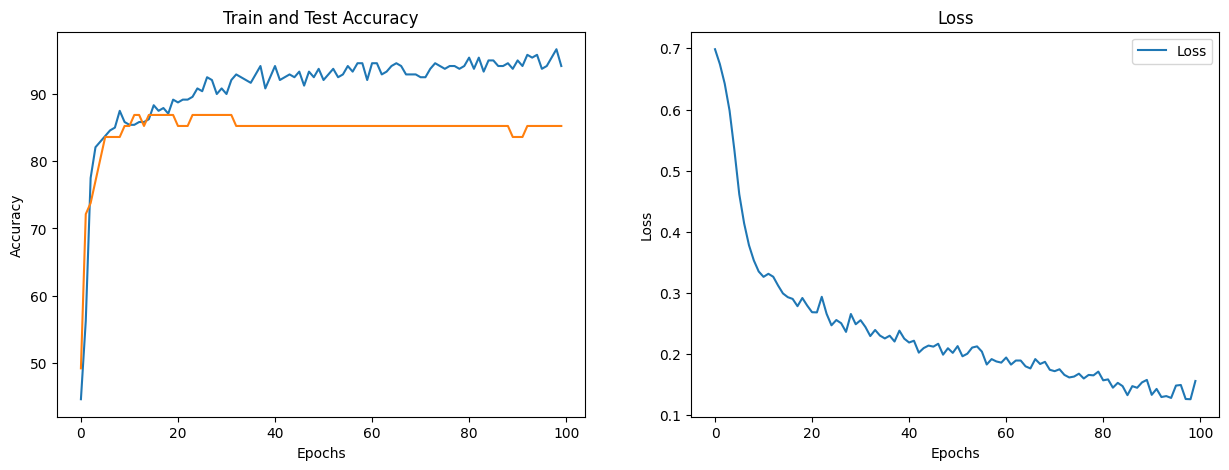

In [361]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(trainAcc, label='Train Accuracy')
ax[0].plot(testAcc, label='Test Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Train and Test Accuracy')

ax[1].plot(losses, label='Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss')
ax[1].legend()
plt.show()


In [389]:
# test the model with a new sample:
import random
# Generate a random sample
sample_scaled = dataScaled.iloc[random.randint(0, len(dataScaled)-1)].values.reshape(1, -1)
# Scale the sample using the same scaler
# Convert to PyTorch tensor
sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

# Make prediction
heartDisease.eval()
with torch.no_grad():
    prediction = heartDisease(sample_tensor)
    prediction_prob = torch.sigmoid(prediction)
    predicted_class = (prediction_prob > 0.5).float()
print(f"Logit: {prediction.item():.4f}, Prob: {prediction_prob.item():.4f}")
print(f"Predicted Class: {int(predicted_class.item())}")


Logit: 2.7181, Prob: 0.9381
Predicted Class: 1
